#### library import

In [1]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

#### vocabulary class
- idx to word: 숫자(int)를 word(string)으로 변환 
- word to idx: 반대

In [2]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

#### Main

In [3]:
if __name__=='__main__':

    img_path = './drive/My Drive/PerspectiveImages/'
    valid_data = pd.read_csv('./valid_data.csv')    # 미리 제외시켜둔 데이터의 이름 저장

#### Label to vocabulary


In [4]:
captions = [name[:-4] for name in valid_data['name']] # eliminate the .jpg
counter = Counter()
for cap in captions:
    for token in cap:
        counter.update(token)
        
words = [word for word, cnt in counter.items()]
vocab = Vocabulary()

for i, word in enumerate(words):
    vocab.add_word(word)

In [5]:
imgs = []
for file_name in tqdm(valid_data['name']):
    img = np.asarray(Image.open(img_path + file_name))
    imgs.append(img)

imgs = np.asarray(imgs)

100%|██████████| 809/809 [00:01<00:00, 760.62it/s]


#### Transform
- normalize 수행 X -> 왜 인지는 모르겠으나 성능 저하

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([140.72191205357143, 142.173804375, 141.2539975], [66.03655501729828, 65.7432860955485, 65.37706592308601]),
])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, imgs, vocab, captions, transform):
        self.imgs = imgs
        self.captions = captions
        self.vocab = vocab
        self.transform = transform
        
    def __getitem__(self, index):
        imgs = self.imgs
        vocab = self.vocab
        captions = self.captions
        
        image = imgs[index]
        if self.transform is not None:
            image = self.transform(image)
        
        tokens = [token for token in captions[index]]
        caption = []
        caption.extend([vocab(token) for token in tokens])
        target = torch.LongTensor(caption)
        
        return image, target
    
    def __len__(self):
        return len(self.imgs)

In [8]:
batch_size = 8
shuffle = True

c = CustomDataset(imgs, vocab, captions, transform)
data_loder = DataLoader(dataset=c,
                       batch_size=batch_size,
                       shuffle=shuffle,
                       )

train_size = int(0.8 * c.__len__())
test_size = c.__len__() - train_size

In [9]:
#torch.manual_seed(10)
train_dataset, test_dataset = data.random_split(c, [train_size, test_size])
train_loder = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loder = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

#### Network
- Depthwise seperable convolution 사용
- MobileNet 구조
- 차이: 마지막 단에서 Adaptive Average pooling 사용

In [10]:
class Depthwise_seperable_conv(nn.Module):
    def __init__(self, in_channel, kernel_per_layer, out_channel, stride=1):
        super(Depthwise_seperable_conv, self).__init__()
        
        self.depthwise = nn.Sequential(nn.Conv2d(in_channel, in_channel*kernel_per_layer, kernel_size=3, stride=stride, groups=in_channel, padding=1),
                                      nn.BatchNorm2d(in_channel*kernel_per_layer),
                                      nn.ReLU()
                                      )
                                       
        self.pointwise = nn.Sequential(nn.Conv2d(in_channel*kernel_per_layer, out_channel, kernel_size=1),
                                      nn.BatchNorm2d(out_channel),
                                      nn.ReLU()
                                      )
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
    
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, final_size):
        super(Net, self).__init__()
        
        # regular convolution
        self.reg_conv_1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1,2))
        self.sep32_1 = Depthwise_seperable_conv(output_dim, 1, output_dim)
        self.sep32_2 = Depthwise_seperable_conv(output_dim, 2, output_dim*2)
        
        self.sep64_1 = Depthwise_seperable_conv(output_dim*2, 1, output_dim*2, stride=(1,2))
        self.sep64_2 = Depthwise_seperable_conv(output_dim*2, 2, output_dim*4)
        
        self.sep128_1 = Depthwise_seperable_conv(output_dim*4, 1, output_dim*4, stride=(1,2))
        self.sep128_2 = Depthwise_seperable_conv(output_dim*4, 1, output_dim*4)
        self.sep128_3 = Depthwise_seperable_conv(output_dim*4, 2, output_dim*8)
        
        self.sep256_1 = Depthwise_seperable_conv(output_dim*8, 1, output_dim*8, stride=(1,2))
        self.sep256_2 = Depthwise_seperable_conv(output_dim*8, 1, output_dim*8)
        self.sep256_3 = Depthwise_seperable_conv(output_dim*8, 2, output_dim*16)

        self.sep512_1 = Depthwise_seperable_conv(output_dim*16, 1, output_dim*32, stride=(1,2))

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # 약간의 ovefitting도 잡아보자!
        self.fc = nn.Sequential(nn.Linear(1024, 1000),
                                #nn.Dropout(0.5),
                                nn.Linear(1000, final_size)
                               )
        
    def forward(self, x):
        feature = self.reg_conv_1(x)
        feature = self.sep32_1(feature)
        feature = self.sep32_2(feature)

        feature = self.sep64_1(feature)
        feature = self.sep64_2(feature)
        
        feature = self.sep128_1(feature)
        feature = self.sep128_2(feature)
        feature = self.sep128_3(feature)
        
        feature = self.sep256_1(feature)
        feature = self.sep256_2(feature)
        feature = self.sep256_3(feature)

        feature = self.sep512_1(feature)
        feature = self.avg_pool(feature)
        feature = self.fc(feature.reshape(feature.shape[0], -1))
        
        return feature

In [11]:
def save_checkpoint(state, filename='MobileNet.path.tar'):
    print(">>> saving checkpoing")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint):
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    optimizer.load_state_dict(torch.load(checkpoint)['optimizer'])

In [12]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.0005
epoch = 200
final_size = 308
vocab_size = len(vocab)
input_dim = train_dataset.dataset.imgs.shape[-1]
output_dim = 32

model = Net(input_dim, output_dim, final_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.2)
#optimizer = optim.Adam(model.parameters(), lr=lr)

checkpoint = 'MobileNet_v3.path.tar'
load_model = False
save_model = False

In [13]:
train_acc_for_epoch = []
test_acc_for_epoch = []
train_loss_for_epoch = []

for e in range(epoch):
    running_loss = 0
    
    model.train()
    train_acc = []
    for _, (image, target) in tqdm(enumerate(train_loder)):
        image = image.to(device)
        target = target.to(device)#type(torch.LongTensor).to(device)
        output = model(image)
        
        loss = 0

        # 배치 내 각각 텐서마다 loss and acc 구하기 
        for idx in range(len(output)):
            
            # 44개(단어 사이즈)로 짤라낸 후 계산
            sliced = torch.cat(torch.split(output[idx], 44, dim=0)).reshape(7, 44)
            
            for i in range(len(sliced)):
                loss += criterion(sliced[i].reshape(1, -1), target[idx][i].reshape(1))
            
            predicted = sliced.argmax(1)
            accuracy = sum(predicted == target[idx]).item() / 7    # 각각의 이미지에서 글자를 얼마나 맞췄는지
            train_acc.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
    train_loss_for_epoch.append(loss.item())
    train_acc_for_epoch.append(np.mean(train_acc))

    print(f'epoch: {e+1}, loss: {loss.item()}, train accuracy: {np.mean(train_acc)}')
    if (e+1) % 5 == 0 :
        if save_model:
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint)
    
    model.eval()
    with torch.no_grad():
        test_acc = []

        for _, (image_t, target_t) in enumerate(test_loder):
            image_t = image_t.to(device)
            target_t = target_t.to(device)#type(torch.LongTensor).to(device)
            output_t = model(image_t)

            # 배치내의 각 샘플마다
            for idx in range(len(output_t)):
                # 44개(단어 사이즈)로 짤라낸 후 계산
                sliced = torch.cat(torch.split(output_t[idx], 44, dim=0)).reshape(7, 44)
                predicted = sliced.argmax(1)

                accuracy = sum(predicted == target_t[idx]).item() / 7
                test_acc.append(accuracy)
        test_acc_for_epoch.append(np.mean(test_acc))
        print(f'epoch: {e+1}, test accuracy: {np.mean(test_acc)}')

81it [00:04, 19.53it/s]


epoch: 1, loss: 121.68402099609375, train accuracy: 0.10156767498344005


3it [00:00, 21.70it/s]

epoch: 1, test accuracy: 0.09259259259259259


81it [00:04, 19.46it/s]


epoch: 2, loss: 121.58126068115234, train accuracy: 0.10951644954736144


3it [00:00, 21.90it/s]

epoch: 2, test accuracy: 0.11022927689594354


81it [00:04, 19.27it/s]


epoch: 3, loss: 123.70365142822266, train accuracy: 0.105762861558843


3it [00:00, 22.07it/s]

epoch: 3, test accuracy: 0.12169312169312167


81it [00:04, 19.23it/s]


epoch: 4, loss: 117.55953979492188, train accuracy: 0.11724442481784057


3it [00:00, 21.17it/s]

epoch: 4, test accuracy: 0.10758377425044088


81it [00:04, 19.41it/s]


epoch: 5, loss: 120.90581512451172, train accuracy: 0.11923161845882091


3it [00:00, 21.72it/s]

epoch: 5, test accuracy: 0.1111111111111111


81it [00:04, 19.14it/s]


epoch: 6, loss: 118.44942474365234, train accuracy: 0.12320600574078162


3it [00:00, 21.68it/s]

epoch: 6, test accuracy: 0.1146384479717813


81it [00:04, 19.42it/s]


epoch: 7, loss: 126.06861877441406, train accuracy: 0.15168911459483328


3it [00:00, 21.00it/s]

epoch: 7, test accuracy: 0.12874779541446207


81it [00:04, 19.36it/s]


epoch: 8, loss: 119.4678726196289, train accuracy: 0.15279311106204457


3it [00:00, 21.40it/s]

epoch: 8, test accuracy: 0.1490299823633157


81it [00:04, 18.84it/s]


epoch: 9, loss: 116.36797332763672, train accuracy: 0.17310664605873258


3it [00:00, 21.72it/s]

epoch: 9, test accuracy: 0.1728395061728395


81it [00:04, 19.08it/s]


epoch: 10, loss: 113.35293579101562, train accuracy: 0.20512254360786047


3it [00:00, 21.27it/s]

epoch: 10, test accuracy: 0.20017636684303344


81it [00:04, 19.41it/s]


epoch: 11, loss: 104.76676940917969, train accuracy: 0.22411128284389487


3it [00:00, 21.47it/s]

epoch: 11, test accuracy: 0.22398589065255728


81it [00:04, 19.46it/s]


epoch: 12, loss: 99.98631286621094, train accuracy: 0.2695959372930006


3it [00:00, 21.97it/s]

epoch: 12, test accuracy: 0.2530864197530864


81it [00:04, 19.50it/s]


epoch: 13, loss: 98.20549774169922, train accuracy: 0.292779863104438


3it [00:00, 21.88it/s]

epoch: 13, test accuracy: 0.3024691358024691


81it [00:04, 19.79it/s]


epoch: 14, loss: 94.99600982666016, train accuracy: 0.338485316846986


3it [00:00, 21.14it/s]

epoch: 14, test accuracy: 0.32010582010582006


81it [00:04, 19.71it/s]


epoch: 15, loss: 83.58032989501953, train accuracy: 0.3671892249944799


3it [00:00, 22.02it/s]

epoch: 15, test accuracy: 0.3571428571428571


81it [00:04, 19.80it/s]


epoch: 16, loss: 83.47272491455078, train accuracy: 0.3981011260763965


3it [00:00, 22.19it/s]

epoch: 16, test accuracy: 0.37477954144620806


81it [00:04, 19.62it/s]


epoch: 17, loss: 75.9728012084961, train accuracy: 0.4257010377566791


3it [00:00, 21.14it/s]

epoch: 17, test accuracy: 0.39153439153439146


81it [00:04, 19.56it/s]


epoch: 18, loss: 81.37164306640625, train accuracy: 0.4521969529697505


3it [00:00, 22.03it/s]

epoch: 18, test accuracy: 0.45326278659611985


81it [00:04, 19.62it/s]


epoch: 19, loss: 91.79598236083984, train accuracy: 0.4714064914992271


3it [00:00, 22.28it/s]

epoch: 19, test accuracy: 0.4091710758377425


81it [00:04, 19.70it/s]


epoch: 20, loss: 77.36308288574219, train accuracy: 0.5089423713844115


3it [00:00, 21.56it/s]

epoch: 20, test accuracy: 0.474426807760141


81it [00:04, 19.50it/s]


epoch: 21, loss: 72.791015625, train accuracy: 0.5285935085007728


3it [00:00, 21.91it/s]

epoch: 21, test accuracy: 0.43915343915343913


81it [00:04, 19.21it/s]


epoch: 22, loss: 91.5900650024414, train accuracy: 0.5564142194744977


3it [00:00, 20.08it/s]

epoch: 22, test accuracy: 0.49382716049382713


81it [00:04, 18.75it/s]


epoch: 23, loss: 56.367435455322266, train accuracy: 0.5873261205564142


3it [00:00, 21.73it/s]

epoch: 23, test accuracy: 0.5423280423280423


81it [00:04, 19.40it/s]


epoch: 24, loss: 52.27854537963867, train accuracy: 0.6089644513137558


3it [00:00, 21.72it/s]

epoch: 24, test accuracy: 0.5529100529100528


81it [00:04, 19.65it/s]


epoch: 25, loss: 60.095096588134766, train accuracy: 0.6268491940825789


3it [00:00, 19.75it/s]

epoch: 25, test accuracy: 0.5220458553791886


81it [00:04, 19.18it/s]


epoch: 26, loss: 53.60676193237305, train accuracy: 0.6429675425038639


3it [00:00, 21.79it/s]

epoch: 26, test accuracy: 0.5793650793650794


81it [00:04, 19.38it/s]


epoch: 27, loss: 54.506126403808594, train accuracy: 0.6694634577169353


3it [00:00, 21.27it/s]

epoch: 27, test accuracy: 0.6119929453262787


81it [00:04, 19.28it/s]


epoch: 28, loss: 43.937042236328125, train accuracy: 0.6972841686906601


3it [00:00, 22.04it/s]

epoch: 28, test accuracy: 0.6172839506172839


81it [00:04, 19.72it/s]


epoch: 29, loss: 43.46247482299805, train accuracy: 0.7061161404283506


3it [00:00, 21.23it/s]

epoch: 29, test accuracy: 0.6225749559082892


81it [00:04, 19.43it/s]


epoch: 30, loss: 36.615299224853516, train accuracy: 0.7134025171119452


3it [00:00, 19.73it/s]

epoch: 30, test accuracy: 0.6216931216931217


81it [00:04, 19.52it/s]


epoch: 31, loss: 38.94622802734375, train accuracy: 0.7361448443364981


3it [00:00, 19.96it/s]

epoch: 31, test accuracy: 0.6578483245149911


81it [00:04, 19.51it/s]


epoch: 32, loss: 29.369606018066406, train accuracy: 0.7549127842790903


3it [00:00, 22.18it/s]

epoch: 32, test accuracy: 0.6428571428571428


81it [00:04, 19.72it/s]


epoch: 33, loss: 51.58988571166992, train accuracy: 0.7679399425921838


3it [00:00, 21.06it/s]

epoch: 33, test accuracy: 0.6622574955908289


81it [00:04, 19.46it/s]


epoch: 34, loss: 30.59123992919922, train accuracy: 0.7714727312872598


3it [00:00, 21.21it/s]

epoch: 34, test accuracy: 0.6851851851851851


81it [00:04, 19.79it/s]


epoch: 35, loss: 20.077808380126953, train accuracy: 0.7915654669905056


3it [00:00, 22.00it/s]

epoch: 35, test accuracy: 0.7098765432098766


81it [00:04, 19.82it/s]


epoch: 36, loss: 40.289306640625, train accuracy: 0.7844998896003532


3it [00:00, 21.31it/s]

epoch: 36, test accuracy: 0.6940035273368605


81it [00:04, 19.71it/s]


epoch: 37, loss: 21.60359001159668, train accuracy: 0.8107750055199822


3it [00:00, 21.75it/s]

epoch: 37, test accuracy: 0.7151675485008818


81it [00:04, 19.69it/s]


epoch: 38, loss: 46.31847381591797, train accuracy: 0.8107750055199822


3it [00:00, 19.79it/s]

epoch: 38, test accuracy: 0.6860670194003526


81it [00:04, 19.41it/s]


epoch: 39, loss: 22.40271759033203, train accuracy: 0.8240229631265179


3it [00:00, 19.30it/s]

epoch: 39, test accuracy: 0.7460317460317459


81it [00:04, 19.46it/s]


epoch: 40, loss: 25.609251022338867, train accuracy: 0.8319717376904393


3it [00:00, 22.34it/s]

epoch: 40, test accuracy: 0.7398589065255731


81it [00:04, 19.81it/s]


epoch: 41, loss: 32.578712463378906, train accuracy: 0.8449988960035325


3it [00:00, 22.11it/s]

epoch: 41, test accuracy: 0.738095238095238


81it [00:04, 19.33it/s]


epoch: 42, loss: 20.526559829711914, train accuracy: 0.8421285051887835


3it [00:00, 21.97it/s]

epoch: 42, test accuracy: 0.7495590828924161


81it [00:04, 19.85it/s]


epoch: 43, loss: 18.324167251586914, train accuracy: 0.8489732832854934


3it [00:00, 22.10it/s]

epoch: 43, test accuracy: 0.7566137566137565


81it [00:04, 19.55it/s]


epoch: 44, loss: 21.43955421447754, train accuracy: 0.8589092514903952


3it [00:00, 21.95it/s]

epoch: 44, test accuracy: 0.7425044091710757


81it [00:04, 19.41it/s]


epoch: 45, loss: 26.778348922729492, train accuracy: 0.8778979907264297


3it [00:00, 20.57it/s]

epoch: 45, test accuracy: 0.738095238095238


81it [00:04, 19.56it/s]


epoch: 46, loss: 16.000547409057617, train accuracy: 0.8739236034444688


3it [00:00, 22.16it/s]

epoch: 46, test accuracy: 0.7222222222222221


81it [00:04, 19.37it/s]


epoch: 47, loss: 15.783447265625, train accuracy: 0.8816515787149479


3it [00:00, 21.80it/s]

epoch: 47, test accuracy: 0.7848324514991182


81it [00:04, 19.76it/s]


epoch: 48, loss: 14.541253089904785, train accuracy: 0.8882755575182161


3it [00:00, 21.79it/s]

epoch: 48, test accuracy: 0.7777777777777777


81it [00:04, 19.56it/s]


epoch: 49, loss: 11.695083618164062, train accuracy: 0.8882755575182159


3it [00:00, 21.94it/s]

epoch: 49, test accuracy: 0.7839506172839505


81it [00:04, 19.34it/s]


epoch: 50, loss: 9.194028854370117, train accuracy: 0.8964451313755796


3it [00:00, 21.84it/s]

epoch: 50, test accuracy: 0.7962962962962963


81it [00:04, 19.79it/s]


epoch: 51, loss: 7.958564758300781, train accuracy: 0.9032899094722895


3it [00:00, 21.90it/s]

epoch: 51, test accuracy: 0.7786596119929452


81it [00:04, 19.33it/s]


epoch: 52, loss: 16.12725067138672, train accuracy: 0.9094722896886729


3it [00:00, 21.68it/s]

epoch: 52, test accuracy: 0.8095238095238095


81it [00:04, 19.62it/s]


epoch: 53, loss: 3.5635344982147217, train accuracy: 0.9107970854493265


3it [00:00, 21.63it/s]

epoch: 53, test accuracy: 0.7724867724867724


81it [00:04, 19.71it/s]


epoch: 54, loss: 10.374456405639648, train accuracy: 0.9107970854493266


3it [00:00, 21.66it/s]

epoch: 54, test accuracy: 0.8112874779541447


81it [00:04, 19.53it/s]


epoch: 55, loss: 19.698945999145508, train accuracy: 0.9240450430558623


3it [00:00, 21.80it/s]

epoch: 55, test accuracy: 0.8156966490299822


81it [00:04, 19.78it/s]


epoch: 56, loss: 15.164179801940918, train accuracy: 0.9200706557739015


3it [00:00, 19.57it/s]

epoch: 56, test accuracy: 0.7592592592592592


81it [00:04, 19.30it/s]


epoch: 57, loss: 4.9222941398620605, train accuracy: 0.9260322366968425


3it [00:00, 22.20it/s]

epoch: 57, test accuracy: 0.8262786596119928


81it [00:04, 19.69it/s]


epoch: 58, loss: 7.876769542694092, train accuracy: 0.9397217928902627


3it [00:00, 21.68it/s]

epoch: 58, test accuracy: 0.7874779541446207


81it [00:04, 19.53it/s]


epoch: 59, loss: 10.195291519165039, train accuracy: 0.9183042614263633


3it [00:00, 21.58it/s]

epoch: 59, test accuracy: 0.8156966490299823


81it [00:04, 19.47it/s]


epoch: 60, loss: 11.409324645996094, train accuracy: 0.9370722013689555


3it [00:00, 22.17it/s]

epoch: 60, test accuracy: 0.7962962962962963


81it [00:04, 19.55it/s]


epoch: 61, loss: 5.604814052581787, train accuracy: 0.9401633914771472


3it [00:00, 21.47it/s]

epoch: 61, test accuracy: 0.8095238095238096


81it [00:04, 19.43it/s]


epoch: 62, loss: 7.747602939605713, train accuracy: 0.9366306027820711


3it [00:00, 21.67it/s]

epoch: 62, test accuracy: 0.8174603174603173


81it [00:04, 19.58it/s]


epoch: 63, loss: 6.723905563354492, train accuracy: 0.9421505851181278


3it [00:00, 21.70it/s]

epoch: 63, test accuracy: 0.8174603174603176


81it [00:04, 19.20it/s]


epoch: 64, loss: 8.530359268188477, train accuracy: 0.9569441377787592


3it [00:00, 20.89it/s]

epoch: 64, test accuracy: 0.810405643738977


81it [00:04, 19.58it/s]


epoch: 65, loss: 4.057572841644287, train accuracy: 0.9368514020755133


3it [00:00, 22.10it/s]

epoch: 65, test accuracy: 0.7768959435626103


81it [00:04, 19.49it/s]


epoch: 66, loss: 8.071249961853027, train accuracy: 0.9556193420181056


3it [00:00, 21.87it/s]

epoch: 66, test accuracy: 0.8165784832451498


81it [00:04, 19.66it/s]


epoch: 67, loss: 14.849120140075684, train accuracy: 0.9531905497902408


3it [00:00, 21.77it/s]

epoch: 67, test accuracy: 0.7945326278659612


81it [00:04, 19.78it/s]


epoch: 68, loss: 3.106867790222168, train accuracy: 0.9452417752263192


3it [00:00, 21.93it/s]

epoch: 68, test accuracy: 0.8253968253968255


81it [00:04, 19.57it/s]


epoch: 69, loss: 4.588176250457764, train accuracy: 0.9642305144623537


3it [00:00, 21.61it/s]

epoch: 69, test accuracy: 0.8165784832451498


81it [00:04, 19.74it/s]


epoch: 70, loss: 5.6984663009643555, train accuracy: 0.9538529476705676


3it [00:00, 21.85it/s]

epoch: 70, test accuracy: 0.792768959435626


81it [00:04, 19.65it/s]


epoch: 71, loss: 11.421345710754395, train accuracy: 0.9518657540295872


3it [00:00, 21.43it/s]

epoch: 71, test accuracy: 0.8262786596119928


81it [00:04, 19.71it/s]


epoch: 72, loss: 5.875214576721191, train accuracy: 0.9613601236476044


3it [00:00, 21.54it/s]

epoch: 72, test accuracy: 0.8333333333333334


81it [00:04, 19.55it/s]


epoch: 73, loss: 2.7479360103607178, train accuracy: 0.9582689335394127


3it [00:00, 22.04it/s]

epoch: 73, test accuracy: 0.8412698412698412


81it [00:04, 19.33it/s]


epoch: 74, loss: 3.6704370975494385, train accuracy: 0.9693088982115257


3it [00:00, 21.29it/s]

epoch: 74, test accuracy: 0.8377425044091711


81it [00:04, 19.40it/s]


epoch: 75, loss: 3.5367534160614014, train accuracy: 0.9529697504967986


3it [00:00, 21.68it/s]

epoch: 75, test accuracy: 0.82010582010582


81it [00:04, 19.46it/s]


epoch: 76, loss: 4.7498345375061035, train accuracy: 0.9693088982115257


3it [00:00, 19.23it/s]

epoch: 76, test accuracy: 0.8386243386243385


81it [00:04, 19.26it/s]


epoch: 77, loss: 6.985103607177734, train accuracy: 0.9679841024508722


2it [00:00, 19.99it/s]

epoch: 77, test accuracy: 0.837742504409171


81it [00:04, 19.50it/s]


epoch: 78, loss: 11.206867218017578, train accuracy: 0.95606094060499


3it [00:00, 21.54it/s]

epoch: 78, test accuracy: 0.8192239858906526


81it [00:04, 19.43it/s]


epoch: 79, loss: 1.8863486051559448, train accuracy: 0.9741664826672554


3it [00:00, 21.50it/s]

epoch: 79, test accuracy: 0.8421516754850087


81it [00:04, 19.58it/s]


epoch: 80, loss: 11.400485038757324, train accuracy: 0.9708544932656215


2it [00:00, 19.88it/s]

epoch: 80, test accuracy: 0.8403880070546735


81it [00:04, 19.52it/s]


epoch: 81, loss: 4.334045886993408, train accuracy: 0.9657761095164495


3it [00:00, 21.98it/s]

epoch: 81, test accuracy: 0.8253968253968255


81it [00:04, 19.76it/s]


epoch: 82, loss: 5.980778694152832, train accuracy: 0.9719584897328329


3it [00:00, 21.53it/s]

epoch: 82, test accuracy: 0.8492063492063491


81it [00:04, 19.51it/s]


epoch: 83, loss: 10.37092113494873, train accuracy: 0.9688672996246412


3it [00:00, 21.61it/s]

epoch: 83, test accuracy: 0.8165784832451498


81it [00:04, 19.65it/s]


epoch: 84, loss: 3.5341105461120605, train accuracy: 0.9739456833738132


2it [00:00, 19.15it/s]

epoch: 84, test accuracy: 0.8430335097001763


81it [00:04, 19.40it/s]


epoch: 85, loss: 6.833345413208008, train accuracy: 0.9701920953852948


3it [00:00, 20.10it/s]

epoch: 85, test accuracy: 0.8245149911816577


81it [00:04, 19.50it/s]


epoch: 86, loss: 2.341500759124756, train accuracy: 0.977920070655774


3it [00:00, 22.05it/s]

epoch: 86, test accuracy: 0.8377425044091711


81it [00:04, 19.49it/s]


epoch: 87, loss: 4.165765285491943, train accuracy: 0.9712960918525061


3it [00:00, 21.21it/s]

epoch: 87, test accuracy: 0.8421516754850086


81it [00:04, 19.28it/s]


epoch: 88, loss: 2.3011152744293213, train accuracy: 0.9708544932656215


3it [00:00, 19.77it/s]

epoch: 88, test accuracy: 0.8333333333333334


81it [00:04, 19.39it/s]


epoch: 89, loss: 2.7479379177093506, train accuracy: 0.9768160741885626


3it [00:00, 21.66it/s]

epoch: 89, test accuracy: 0.8465608465608464


81it [00:04, 19.53it/s]


epoch: 90, loss: 5.835396766662598, train accuracy: 0.9697504967984104


3it [00:00, 21.07it/s]

epoch: 90, test accuracy: 0.8447971781305114


81it [00:04, 19.42it/s]


epoch: 91, loss: 2.513068437576294, train accuracy: 0.977920070655774


3it [00:00, 22.05it/s]

epoch: 91, test accuracy: 0.8606701940035273


81it [00:04, 19.33it/s]


epoch: 92, loss: 1.308592677116394, train accuracy: 0.98145285935085


3it [00:00, 21.80it/s]

epoch: 92, test accuracy: 0.8245149911816577


81it [00:04, 19.70it/s]


epoch: 93, loss: 1.275579571723938, train accuracy: 0.9774784720688896


3it [00:00, 22.19it/s]

epoch: 93, test accuracy: 0.8492063492063491


81it [00:04, 19.63it/s]


epoch: 94, loss: 6.38277006149292, train accuracy: 0.9695296975049679


3it [00:00, 20.84it/s]

epoch: 94, test accuracy: 0.8236331569664901


81it [00:04, 19.55it/s]


epoch: 95, loss: 5.421703338623047, train accuracy: 0.9728416869066019


3it [00:00, 22.01it/s]

epoch: 95, test accuracy: 0.843915343915344


81it [00:04, 19.22it/s]


epoch: 96, loss: 1.3816933631896973, train accuracy: 0.9829984544049459


3it [00:00, 22.04it/s]

epoch: 96, test accuracy: 0.8527336860670192


81it [00:04, 19.79it/s]


epoch: 97, loss: 0.5944080948829651, train accuracy: 0.9869728416869066


3it [00:00, 21.57it/s]

epoch: 97, test accuracy: 0.8659611992945325


81it [00:04, 19.55it/s]


epoch: 98, loss: 3.2426655292510986, train accuracy: 0.9748288805475823


3it [00:00, 21.93it/s]

epoch: 98, test accuracy: 0.8095238095238095


81it [00:04, 19.76it/s]


epoch: 99, loss: 3.3781003952026367, train accuracy: 0.9834400529918305


3it [00:00, 21.88it/s]

epoch: 99, test accuracy: 0.857142857142857


81it [00:04, 19.22it/s]


epoch: 100, loss: 9.641400337219238, train accuracy: 0.9858688452196953


3it [00:00, 21.98it/s]

epoch: 100, test accuracy: 0.834215167548501


81it [00:04, 19.57it/s]


epoch: 101, loss: 4.232768535614014, train accuracy: 0.9849856480459261


3it [00:00, 21.31it/s]

epoch: 101, test accuracy: 0.8051146384479717


81it [00:04, 19.67it/s]


epoch: 102, loss: 2.694211959838867, train accuracy: 0.9768160741885626


3it [00:00, 22.02it/s]

epoch: 102, test accuracy: 0.8624338624338623


81it [00:04, 19.67it/s]


epoch: 103, loss: 5.748403549194336, train accuracy: 0.9841024508721573


3it [00:00, 20.06it/s]

epoch: 103, test accuracy: 0.8386243386243385


81it [00:04, 19.46it/s]


epoch: 104, loss: 1.6204724311828613, train accuracy: 0.9849856480459265


3it [00:00, 20.10it/s]

epoch: 104, test accuracy: 0.8527336860670192


81it [00:04, 19.67it/s]


epoch: 105, loss: 0.3767976760864258, train accuracy: 0.9765952748951204


3it [00:00, 21.65it/s]

epoch: 105, test accuracy: 0.8483245149911814


81it [00:04, 19.58it/s]


epoch: 106, loss: 9.044451713562012, train accuracy: 0.9865312431000222


3it [00:00, 21.77it/s]

epoch: 106, test accuracy: 0.8518518518518516


81it [00:04, 19.52it/s]


epoch: 107, loss: 1.1533246040344238, train accuracy: 0.9865312431000219


3it [00:00, 21.37it/s]

epoch: 107, test accuracy: 0.8553791887125219


81it [00:04, 19.01it/s]


epoch: 108, loss: 3.969856023788452, train accuracy: 0.9803488628836389


3it [00:00, 20.68it/s]

epoch: 108, test accuracy: 0.857142857142857


81it [00:04, 19.46it/s]


epoch: 109, loss: 3.7852935791015625, train accuracy: 0.9799072642967542


3it [00:00, 21.96it/s]

epoch: 109, test accuracy: 0.8492063492063493


81it [00:04, 19.59it/s]


epoch: 110, loss: 0.3584519922733307, train accuracy: 0.9827776551115037


3it [00:00, 21.77it/s]

epoch: 110, test accuracy: 0.8633156966490299


81it [00:04, 19.47it/s]


epoch: 111, loss: 0.5847046375274658, train accuracy: 0.9902848310885406


3it [00:00, 22.21it/s]

epoch: 111, test accuracy: 0.8677248677248677


81it [00:04, 19.28it/s]


epoch: 112, loss: 27.395383834838867, train accuracy: 0.9807904614705234


3it [00:00, 21.98it/s]

epoch: 112, test accuracy: 0.818342151675485


81it [00:04, 19.80it/s]


epoch: 113, loss: 2.527515411376953, train accuracy: 0.9812320600574078


3it [00:00, 21.82it/s]

epoch: 113, test accuracy: 0.8562610229276897


81it [00:04, 19.62it/s]


epoch: 114, loss: 1.1818722486495972, train accuracy: 0.9909472289688672


3it [00:00, 22.13it/s]

epoch: 114, test accuracy: 0.8430335097001763


81it [00:04, 19.80it/s]


epoch: 115, loss: 2.0359230041503906, train accuracy: 0.9792448664164275


3it [00:00, 21.36it/s]

epoch: 115, test accuracy: 0.8544973544973546


81it [00:04, 19.30it/s]


epoch: 116, loss: 0.5879467725753784, train accuracy: 0.9929344226098477


3it [00:00, 22.14it/s]

epoch: 116, test accuracy: 0.8712522045855378


81it [00:04, 19.25it/s]


epoch: 117, loss: 19.029094696044922, train accuracy: 0.9827776551115037


3it [00:00, 22.00it/s]

epoch: 117, test accuracy: 0.847442680776014


81it [00:04, 19.36it/s]


epoch: 118, loss: 4.137151718139648, train accuracy: 0.9781408699492162


3it [00:00, 20.54it/s]

epoch: 118, test accuracy: 0.8447971781305114


81it [00:04, 19.23it/s]


epoch: 119, loss: 8.80519962310791, train accuracy: 0.9898432325016562


3it [00:00, 19.68it/s]

epoch: 119, test accuracy: 0.847442680776014


81it [00:04, 19.52it/s]


epoch: 120, loss: 0.46705761551856995, train accuracy: 0.9825568558180615


3it [00:00, 22.06it/s]

epoch: 120, test accuracy: 0.8633156966490299


81it [00:04, 19.53it/s]


epoch: 121, loss: 0.3148985207080841, train accuracy: 0.9900640317950983


3it [00:00, 21.90it/s]

epoch: 121, test accuracy: 0.8500881834215168


81it [00:04, 19.79it/s]


epoch: 122, loss: 1.3656868934631348, train accuracy: 0.9878560388606756


3it [00:00, 21.98it/s]

epoch: 122, test accuracy: 0.86331569664903


81it [00:04, 19.52it/s]


epoch: 123, loss: 0.22692734003067017, train accuracy: 0.9931552219032901


3it [00:00, 21.86it/s]

epoch: 123, test accuracy: 0.8774250440917105


81it [00:04, 19.71it/s]


epoch: 124, loss: 1.2361774444580078, train accuracy: 0.9825568558180615


3it [00:00, 21.52it/s]

epoch: 124, test accuracy: 0.8553791887125219


81it [00:04, 19.52it/s]


epoch: 125, loss: 2.1897470951080322, train accuracy: 0.9898432325016561


3it [00:00, 20.11it/s]

epoch: 125, test accuracy: 0.8659611992945325


81it [00:04, 19.51it/s]


epoch: 126, loss: 2.720451593399048, train accuracy: 0.9896224332082136


3it [00:00, 21.97it/s]

epoch: 126, test accuracy: 0.8730158730158731


81it [00:04, 19.31it/s]


epoch: 127, loss: 0.49501633644104004, train accuracy: 0.9827776551115037


3it [00:00, 22.10it/s]

epoch: 127, test accuracy: 0.8562610229276895


81it [00:04, 19.31it/s]


epoch: 128, loss: 0.5961345434188843, train accuracy: 0.9942592183705012


3it [00:00, 22.16it/s]

epoch: 128, test accuracy: 0.8562610229276895


81it [00:04, 19.69it/s]


epoch: 129, loss: 1.6913546323776245, train accuracy: 0.9841024508721571


3it [00:00, 21.60it/s]

epoch: 129, test accuracy: 0.8677248677248677


81it [00:04, 19.38it/s]


epoch: 130, loss: 0.3758549094200134, train accuracy: 0.9905056303819828


3it [00:00, 19.96it/s]

epoch: 130, test accuracy: 0.8774250440917105


81it [00:04, 19.58it/s]


epoch: 131, loss: 6.666873931884766, train accuracy: 0.988960035327887


3it [00:00, 21.72it/s]

epoch: 131, test accuracy: 0.8624338624338624


81it [00:04, 19.36it/s]


epoch: 132, loss: 0.9635158181190491, train accuracy: 0.9878560388606756


2it [00:00, 19.73it/s]

epoch: 132, test accuracy: 0.8686067019400353


81it [00:04, 19.41it/s]


epoch: 133, loss: 9.146249771118164, train accuracy: 0.9918304261426364


3it [00:00, 21.75it/s]

epoch: 133, test accuracy: 0.8694885361552028


81it [00:04, 19.75it/s]


epoch: 134, loss: 0.13030701875686646, train accuracy: 0.9847648487524839


3it [00:00, 21.95it/s]

epoch: 134, test accuracy: 0.86331569664903


81it [00:04, 19.76it/s]


epoch: 135, loss: 2.0798497200012207, train accuracy: 0.9929344226098477


3it [00:00, 21.57it/s]

epoch: 135, test accuracy: 0.8659611992945325


81it [00:04, 19.26it/s]


epoch: 136, loss: 1.0636088848114014, train accuracy: 0.9843232501655995


3it [00:00, 21.51it/s]

epoch: 136, test accuracy: 0.8765432098765432


81it [00:04, 19.35it/s]


epoch: 137, loss: 1.4074060916900635, train accuracy: 0.9902848310885406


3it [00:00, 20.33it/s]

epoch: 137, test accuracy: 0.880952380952381


81it [00:04, 19.45it/s]


epoch: 138, loss: 3.8280584812164307, train accuracy: 0.9927136233164054


3it [00:00, 21.87it/s]

epoch: 138, test accuracy: 0.8562610229276897


81it [00:04, 19.32it/s]


epoch: 139, loss: 3.8514835834503174, train accuracy: 0.9887392360344448


3it [00:00, 21.40it/s]

epoch: 139, test accuracy: 0.874779541446208


81it [00:04, 19.77it/s]


epoch: 140, loss: 4.798534393310547, train accuracy: 0.9827776551115037


3it [00:00, 21.17it/s]

epoch: 140, test accuracy: 0.8589065255731922


81it [00:04, 19.72it/s]


epoch: 141, loss: 0.24679842591285706, train accuracy: 0.9929344226098477


3it [00:00, 19.79it/s]

epoch: 141, test accuracy: 0.880952380952381


81it [00:04, 19.56it/s]


epoch: 142, loss: 4.43446159362793, train accuracy: 0.9894016339147714


3it [00:00, 21.27it/s]

epoch: 142, test accuracy: 0.8747795414462082


81it [00:04, 19.57it/s]


epoch: 143, loss: 2.7269866466522217, train accuracy: 0.9829984544049459


3it [00:00, 21.87it/s]

epoch: 143, test accuracy: 0.8668430335097002


81it [00:04, 19.44it/s]


epoch: 144, loss: 0.07494737952947617, train accuracy: 0.9955840141311549


3it [00:00, 21.90it/s]

epoch: 144, test accuracy: 0.8774250440917107


81it [00:04, 19.66it/s]


epoch: 145, loss: 0.10276709496974945, train accuracy: 0.9955840141311547


3it [00:00, 20.25it/s]

epoch: 145, test accuracy: 0.8597883597883598


81it [00:04, 19.58it/s]


epoch: 146, loss: 5.739408493041992, train accuracy: 0.9894016339147714


3it [00:00, 19.51it/s]

epoch: 146, test accuracy: 0.8783068783068783


81it [00:04, 19.52it/s]


epoch: 147, loss: 1.9143913984298706, train accuracy: 0.9905056303819828


3it [00:00, 21.60it/s]

epoch: 147, test accuracy: 0.8783068783068783


81it [00:04, 19.64it/s]


epoch: 148, loss: 0.28618890047073364, train accuracy: 0.9947008169573857


3it [00:00, 19.85it/s]

epoch: 148, test accuracy: 0.8844797178130511


81it [00:04, 19.35it/s]


epoch: 149, loss: 1.4272822141647339, train accuracy: 0.9898432325016562


3it [00:00, 21.92it/s]

epoch: 149, test accuracy: 0.8527336860670194


81it [00:04, 19.52it/s]


epoch: 150, loss: 0.35822054743766785, train accuracy: 0.9878560388606756


3it [00:00, 21.92it/s]

epoch: 150, test accuracy: 0.8738977072310404


81it [00:04, 19.52it/s]


epoch: 151, loss: 1.388149380683899, train accuracy: 0.9858688452196953


3it [00:00, 20.00it/s]

epoch: 151, test accuracy: 0.874779541446208


81it [00:04, 19.30it/s]


epoch: 152, loss: 1.0427770614624023, train accuracy: 0.9909472289688672


3it [00:00, 21.67it/s]

epoch: 152, test accuracy: 0.8580246913580247


81it [00:04, 19.36it/s]


epoch: 153, loss: 0.6396456360816956, train accuracy: 0.9916096268491942


3it [00:00, 21.96it/s]

epoch: 153, test accuracy: 0.8730158730158729


81it [00:04, 19.72it/s]


epoch: 154, loss: 0.3898448944091797, train accuracy: 0.9894016339147716


3it [00:00, 21.98it/s]

epoch: 154, test accuracy: 0.8800705467372133


81it [00:04, 19.72it/s]


epoch: 155, loss: 0.10490335524082184, train accuracy: 0.9960256127180395


3it [00:00, 19.79it/s]

epoch: 155, test accuracy: 0.8738977072310404


81it [00:04, 19.65it/s]


epoch: 156, loss: 1.6386359930038452, train accuracy: 0.9929344226098477


3it [00:00, 22.13it/s]

epoch: 156, test accuracy: 0.8589065255731922


81it [00:04, 19.70it/s]


epoch: 157, loss: 0.6065552830696106, train accuracy: 0.9894016339147716


3it [00:00, 19.71it/s]

epoch: 157, test accuracy: 0.8765432098765432


81it [00:04, 19.42it/s]


epoch: 158, loss: 4.755800724029541, train accuracy: 0.9882976374475602


3it [00:00, 21.77it/s]

epoch: 158, test accuracy: 0.8853615520282188


81it [00:04, 19.45it/s]


epoch: 159, loss: 0.13118651509284973, train accuracy: 0.9882976374475602


3it [00:00, 21.95it/s]

epoch: 159, test accuracy: 0.8703703703703703


81it [00:04, 19.42it/s]


epoch: 160, loss: 4.918859004974365, train accuracy: 0.9973504084786929


3it [00:00, 21.50it/s]

epoch: 160, test accuracy: 0.8827160493827161


81it [00:04, 19.67it/s]


epoch: 161, loss: 2.5567994117736816, train accuracy: 0.9913888275557519


3it [00:00, 20.69it/s]

epoch: 161, test accuracy: 0.8659611992945325


81it [00:04, 19.73it/s]


epoch: 162, loss: 0.448483407497406, train accuracy: 0.9942592183705012


3it [00:00, 22.00it/s]

epoch: 162, test accuracy: 0.8791887125220458


81it [00:04, 19.21it/s]


epoch: 163, loss: 2.2643918991088867, train accuracy: 0.9942592183705012


3it [00:00, 20.86it/s]

epoch: 163, test accuracy: 0.8703703703703703


81it [00:04, 19.42it/s]


epoch: 164, loss: 3.7315170764923096, train accuracy: 0.9909472289688672


3it [00:00, 21.55it/s]

epoch: 164, test accuracy: 0.8756613756613755


81it [00:04, 19.51it/s]


epoch: 165, loss: 0.9336467981338501, train accuracy: 0.9911680282623097


3it [00:00, 20.00it/s]

epoch: 165, test accuracy: 0.8765432098765432


81it [00:04, 19.63it/s]


epoch: 166, loss: 0.13538843393325806, train accuracy: 0.9962464120114817


3it [00:00, 22.03it/s]

epoch: 166, test accuracy: 0.8835978835978834


81it [00:04, 19.67it/s]


epoch: 167, loss: 4.138615131378174, train accuracy: 0.9953632148377125


3it [00:00, 22.16it/s]

epoch: 167, test accuracy: 0.8527336860670194


81it [00:04, 19.47it/s]


epoch: 168, loss: 1.4162780046463013, train accuracy: 0.9891808346213292


3it [00:00, 20.57it/s]

epoch: 168, test accuracy: 0.8712522045855379


81it [00:04, 19.70it/s]


epoch: 169, loss: 1.1155362129211426, train accuracy: 0.9896224332082136


3it [00:00, 22.31it/s]

epoch: 169, test accuracy: 0.8862433862433862


81it [00:04, 19.72it/s]


epoch: 170, loss: 2.341097354888916, train accuracy: 0.9971296091852505


3it [00:00, 21.97it/s]

epoch: 170, test accuracy: 0.8977072310405643


81it [00:04, 19.13it/s]


epoch: 171, loss: 2.1642613410949707, train accuracy: 0.9922720247295209


3it [00:00, 20.50it/s]

epoch: 171, test accuracy: 0.8765432098765432


81it [00:04, 19.59it/s]


epoch: 172, loss: 1.7873471975326538, train accuracy: 0.9887392360344448


3it [00:00, 22.27it/s]

epoch: 172, test accuracy: 0.8835978835978836


81it [00:04, 19.77it/s]


epoch: 173, loss: 1.5012556314468384, train accuracy: 0.9951424155442703


3it [00:00, 21.98it/s]

epoch: 173, test accuracy: 0.8721340388007054


81it [00:04, 19.83it/s]


epoch: 174, loss: 2.0623226165771484, train accuracy: 0.9876352395672334


3it [00:00, 20.77it/s]

epoch: 174, test accuracy: 0.879188712522046


81it [00:04, 19.68it/s]


epoch: 175, loss: 0.3333190381526947, train accuracy: 0.9894016339147714


3it [00:00, 21.55it/s]

epoch: 175, test accuracy: 0.8756613756613755


81it [00:04, 19.61it/s]


epoch: 176, loss: 0.13972409069538116, train accuracy: 0.9931552219032901


3it [00:00, 22.01it/s]

epoch: 176, test accuracy: 0.8888888888888888


81it [00:04, 19.32it/s]


epoch: 177, loss: 0.9326615333557129, train accuracy: 0.9960256127180394


3it [00:00, 21.46it/s]

epoch: 177, test accuracy: 0.8862433862433862


81it [00:04, 19.79it/s]


epoch: 178, loss: 3.19283127784729, train accuracy: 0.9918304261426364


2it [00:00, 19.38it/s]

epoch: 178, test accuracy: 0.8853615520282188


81it [00:04, 19.03it/s]


epoch: 179, loss: 0.13582918047904968, train accuracy: 0.9958048134245971


3it [00:00, 22.18it/s]

epoch: 179, test accuracy: 0.8765432098765432


81it [00:04, 19.40it/s]


epoch: 180, loss: 1.2975386381149292, train accuracy: 0.9887392360344448


3it [00:00, 21.32it/s]

epoch: 180, test accuracy: 0.8800705467372133


81it [00:04, 19.62it/s]


epoch: 181, loss: 0.3254077732563019, train accuracy: 0.9885184367410026


3it [00:00, 22.07it/s]

epoch: 181, test accuracy: 0.8862433862433862


81it [00:04, 19.53it/s]


epoch: 182, loss: 5.297599792480469, train accuracy: 0.9933760211967323


3it [00:00, 21.67it/s]

epoch: 182, test accuracy: 0.8844797178130511


81it [00:04, 19.33it/s]


epoch: 183, loss: 5.190472602844238, train accuracy: 0.9962464120114817


3it [00:00, 21.90it/s]

epoch: 183, test accuracy: 0.8659611992945325


81it [00:04, 19.46it/s]


epoch: 184, loss: 0.0759730413556099, train accuracy: 0.9902848310885406


3it [00:00, 22.24it/s]

epoch: 184, test accuracy: 0.8906525573192239


81it [00:04, 19.32it/s]


epoch: 185, loss: 0.548871636390686, train accuracy: 0.9973504084786929


3it [00:00, 21.82it/s]

epoch: 185, test accuracy: 0.8968253968253967


81it [00:04, 19.50it/s]


epoch: 186, loss: 3.562014102935791, train accuracy: 0.9905056303819828


3it [00:00, 22.09it/s]

epoch: 186, test accuracy: 0.8641975308641975


81it [00:04, 19.51it/s]


epoch: 187, loss: 5.007471084594727, train accuracy: 0.9918304261426364


3it [00:00, 21.79it/s]

epoch: 187, test accuracy: 0.8765432098765432


81it [00:04, 19.79it/s]


epoch: 188, loss: 0.8414362072944641, train accuracy: 0.9938176197836167


3it [00:00, 22.04it/s]

epoch: 188, test accuracy: 0.8950617283950617


81it [00:04, 19.21it/s]


epoch: 189, loss: 1.93122136592865, train accuracy: 0.9913888275557516


3it [00:00, 21.58it/s]

epoch: 189, test accuracy: 0.8827160493827161


81it [00:04, 19.28it/s]


epoch: 190, loss: 8.768939018249512, train accuracy: 0.9953632148377125


3it [00:00, 22.22it/s]

epoch: 190, test accuracy: 0.8800705467372133


81it [00:04, 19.50it/s]


epoch: 191, loss: 7.22905158996582, train accuracy: 0.9927136233164054


3it [00:00, 21.64it/s]

epoch: 191, test accuracy: 0.8738977072310407


81it [00:04, 19.47it/s]


epoch: 192, loss: 0.15734946727752686, train accuracy: 0.9931552219032901


3it [00:00, 22.15it/s]

epoch: 192, test accuracy: 0.8959435626102292


81it [00:04, 19.52it/s]


epoch: 193, loss: 0.38679543137550354, train accuracy: 0.9973504084786929


3it [00:00, 21.20it/s]

epoch: 193, test accuracy: 0.8915343915343916


81it [00:04, 19.74it/s]


epoch: 194, loss: 0.6817861795425415, train accuracy: 0.9924928240229631


3it [00:00, 21.65it/s]

epoch: 194, test accuracy: 0.8888888888888888


81it [00:04, 19.37it/s]


epoch: 195, loss: 3.9888482093811035, train accuracy: 0.9935968204901745


2it [00:00, 19.88it/s]

epoch: 195, test accuracy: 0.8871252204585538


81it [00:04, 19.59it/s]


epoch: 196, loss: 0.8172277808189392, train accuracy: 0.9927136233164053


3it [00:00, 21.82it/s]

epoch: 196, test accuracy: 0.8835978835978836


81it [00:04, 19.83it/s]


epoch: 197, loss: 1.7101441621780396, train accuracy: 0.9984544049459042


3it [00:00, 20.47it/s]

epoch: 197, test accuracy: 0.8941798941798942


81it [00:04, 19.36it/s]


epoch: 198, loss: 6.809539318084717, train accuracy: 0.9955840141311547


3it [00:00, 21.79it/s]

epoch: 198, test accuracy: 0.8703703703703703


81it [00:04, 19.37it/s]


epoch: 199, loss: 0.8815645575523376, train accuracy: 0.9902848310885406


3it [00:00, 19.06it/s]

epoch: 199, test accuracy: 0.8862433862433862


81it [00:04, 19.52it/s]


epoch: 200, loss: 0.6613346934318542, train accuracy: 0.9975712077721351
epoch: 200, test accuracy: 0.8968253968253967


In [17]:
#### Test for sampling

def do_sample(data, vocab):
    res = []
    for i in data:
        res.append(vocab.idx2word[i.item()])
    return res

model.eval()
with torch.no_grad():
    test_acc = []
    idx_instance = 0
    for _, (image, target) in tqdm(enumerate(test_loder)):
        image = image.to(device)
        target = target.to(device)#type(torch.LongTensor).to(device)
        output_t = model(image)

        # 배치내의 각 샘플마다
        for idx in range(len(output_t)):
            # 44개(단어 사이즈)로 짤라낸 후 계산
            sliced = torch.cat(torch.split(output_t[idx], 44, dim=0)).reshape(7, 44) 
            predicted = sliced.argmax(1)

            accuracy = sum(predicted == target[idx]).item() / 7
            test_acc.append(accuracy)
            print(f'{idx_instance+1}th target: {do_sample(target[idx], vocab)}')
            print(f'{idx_instance+1}th predicted: {do_sample(predicted, vocab)}')
            print()
            print('========================================')
            
            idx_instance += 1
    print(f'acc: {e}, accuracy: {np.mean(test_acc)}')

4it [00:00, 34.77it/s]

1th target: ['4', '8', '구', '0', '7', '4', '9']
1th predicted: ['4', '8', '구', '0', '7', '4', '9']

2th target: ['0', '5', '누', '6', '1', '0', '9']
2th predicted: ['0', '5', '두', '6', '1', '0', '9']

3th target: ['2', '4', '라', '6', '7', '9', '1']
3th predicted: ['2', '4', '러', '6', '7', '9', '1']

4th target: ['3', '6', '로', '5', '6', '7', '4']
4th predicted: ['3', '6', '로', '5', '6', '7', '4']

5th target: ['2', '3', '조', '7', '8', '8', '4']
5th predicted: ['2', '3', '조', '7', '8', '8', '4']

6th target: ['0', '1', '도', '0', '9', '8', '2']
6th predicted: ['0', '1', '도', '0', '9', '5', '2']

7th target: ['2', '1', '소', '2', '0', '7', '7']
7th predicted: ['2', '1', '모', '2', '9', '6', '7']

8th target: ['6', '9', '모', '3', '1', '9', '8']
8th predicted: ['6', '9', '더', '3', '1', '9', '8']

9th target: ['3', '0', '고', '0', '4', '5', '4']
9th predicted: ['3', '0', '고', '0', '4', '5', '4']

10th target: ['1', '3', '루', '2', '4', '4', '7']
10th predicted: ['1', '3', '로', '2', '4', '4', '7']

13it [00:00, 36.68it/s]

62th target: ['3', '1', '로', '2', '0', '0', '4']
62th predicted: ['3', '1', '루', '2', '0', '0', '4']

63th target: ['6', '2', '머', '4', '9', '5', '7']
63th predicted: ['6', '2', '머', '4', '9', '5', '7']

64th target: ['4', '2', '누', '7', '4', '0', '9']
64th predicted: ['4', '2', '로', '7', '6', '0', '9']

65th target: ['6', '8', '버', '0', '9', '9', '5']
65th predicted: ['3', '8', '버', '0', '9', '9', '5']

66th target: ['5', '7', '고', '4', '5', '1', '1']
66th predicted: ['5', '7', '고', '4', '5', '1', '1']

67th target: ['3', '4', '노', '9', '3', '1', '9']
67th predicted: ['3', '4', '노', '9', '3', '1', '9']

68th target: ['2', '4', '저', '8', '8', '9', '7']
68th predicted: ['2', '4', '저', '8', '8', '9', '7']

69th target: ['7', '5', '하', '7', '2', '3', '6']
69th predicted: ['2', '5', '오', '7', '2', '3', '6']

70th target: ['6', '1', '고', '3', '7', '7', '5']
70th predicted: ['8', '1', '고', '3', '7', '7', '5']

71th target: ['2', '6', '소', '6', '6', '1', '9']
71th predicted: ['2', '6', '소', '

21it [00:00, 40.50it/s]

128th target: ['5', '2', '가', '8', '0', '4', '4']
128th predicted: ['5', '2', '거', '8', '0', '4', '4']

129th target: ['4', '7', '부', '7', '0', '7', '0']
129th predicted: ['4', '7', '부', '7', '0', '7', '0']

130th target: ['3', '4', '소', '4', '9', '7', '4']
130th predicted: ['3', '4', '소', '4', '9', '7', '4']

131th target: ['4', '8', '오', '2', '2', '2', '4']
131th predicted: ['4', '8', '오', '2', '2', '2', '4']

132th target: ['3', '6', '루', '1', '4', '1', '2']
132th predicted: ['3', '6', '루', '1', '3', '1', '2']

133th target: ['7', '3', '라', '7', '6', '7', '3']
133th predicted: ['9', '3', '러', '7', '6', '7', '3']

134th target: ['5', '3', '거', '1', '3', '7', '5']
134th predicted: ['5', '3', '러', '1', '3', '7', '5']

135th target: ['1', '9', '라', '0', '9', '1', '6']
135th predicted: ['1', '9', '라', '0', '9', '1', '6']

136th target: ['3', '1', '우', '3', '0', '6', '9']
136th predicted: ['3', '1', '우', '3', '0', '6', '9']

137th target: ['5', '3', '우', '1', '6', '6', '8']
137th predicte

#### Conclusion

- Image captioning 방법으로 시도했을 때 CNN에서 feature 학습을 잘 못한다.
  - 해당 방법은 CNN부분을 pre-trained 네트워크를 사용해야할 것 같다.


- Image captioning 대신 multi class 문제로 모델링
  - CNN으로 추출한 feature vector를 단어 개수인 7 묶음 잘라서 분류.
  - 각각의 data 당 7개의 label을 예측해야 하므로 sequential multi class 문제로 정의


- 기존의 CNN구조로 문제를 해결하려했을 때...
  - Model이 feature extraction을 잘 못함 -> deep 하게 만들어야 한다.


- MobileNet은 작은 image도 매우 deep한 모델로 만들 수 있다.
  - 현재 해결하려는 문제의 데이터셋이 작으므로 MobileNet 구조를 이용하였다. (Residual learning은 적용하지 않았다.)


- MobileNet의 구조를 그대로 따라하니 엄청난 Overfitting 발생.
  - Train acc = 99%, Test acc = 10%

  - 이를 해결하기 위해 여러가지 방법 시도
    1. classifier를 좀 길게 만들고 Dropout을 적용 -> Feature vector를 그대로 분류하는 데 사용하는 것이라 효과가 좋지 않은 것 같다.
    2. Ooptimizer에 Momentum적용 -> 0.1 이상하면 학습 불안정
    3. Model의 구조를 Compact하게 바꾸거나, 완전 Deep하게 구성 -> Compact하게 적용하니 어느정도의 overfitting을 피할 수 있었음. 반대로 Deep하게 구성하면 성능 저하


- 모델을 Compact하게 구성하고 학습 파라미터를 적게 만들기 위해 flatten과정을 제외
  - 대신 Adaptive average pooling으로 간단하게 구성
  - compact한 모델에서 dropout을 하나 해주니 성능 향상

#### 결과

In [18]:
print('Max train accuracy: ', np.max(train_acc_for_epoch))
print('Max test accuracy: ', np.max(test_acc_for_epoch))

Max train accuracy:  0.9984544049459042
Max test accuracy:  0.8977072310405643


Text(0.5, 0, 'Epoch')

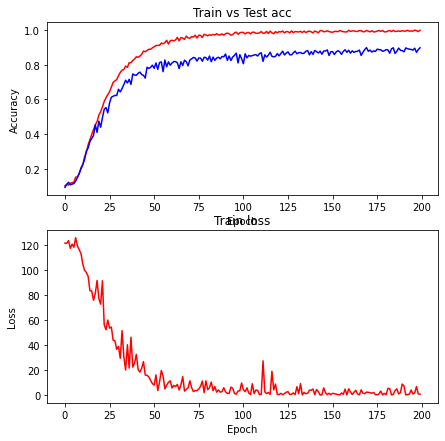

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(7,7))
ax[0].plot(train_acc_for_epoch, color='red')
ax[0].plot(test_acc_for_epoch, color='blue')
ax[0].set_title('Train vs Test acc')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(train_loss_for_epoch, color='red')
ax[1].set_title('Train loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
